# 07 - Advanced: MaxCut with QAOA

This notebook builds a small MaxCut-QAOA pipeline with the tensor surrogate API:
1. Define a graph and MaxCut objective
2. Build a QAOA circuit
3. Train QAOA angles by minimizing `sum Z_i Z_j` over edges
4. Compare against brute-force classical optimum
5. Draw samples from the trained circuit (PennyLane reference path)


In [4]:
import os
import sys

try:
    cwd = os.getcwd()
except FileNotFoundError:
    cwd = os.environ.get("PWD", os.path.expanduser("~"))

    
import numpy as np
import torch
from matplotlib import pyplot as plt


sys.path.append('/home/ubuntu/PPS-lab')
from src.pauli_surrogate_python import CliffordGate, PauliRotation, PauliSum
from src_tensor.api import compile_expval_program, pennylane_sample_small

## Graph and objective

For MaxCut on graph `G=(V,E)`, maximizing cut size is equivalent to minimizing:
`sum_{(i,j) in E} <Z_i Z_j>`.

Expected cut can be recovered as:
`E[cut] = (|E| - sum_<ZZ>)/2`.

In [5]:
# Medium graph example
n_qubits = 15

# Build an undirected graph: ring + long-range chords
edge_set = set()
for i in range(n_qubits):
    # Ring edge
    u, v = i, (i + 1) % n_qubits
    edge_set.add((u, v) if u < v else (v, u))

    # Long-range chord
    u2, v2 = i, (i + 7) % n_qubits
    edge_set.add((u2, v2) if u2 < v2 else (v2, u2))

edges = sorted(edge_set)
m_edges = len(edges)

zz_obj = PauliSum(n_qubits)
for u, v in edges:
    zz_obj.add_from_str('ZZ', 1.0, qubits=[u, v])

print('n_qubits:', n_qubits, 'n_edges:', m_edges)


n_qubits: 15 n_edges: 30


## Build QAOA circuit

QAOA layer:
- Cost unitary: `exp(-i gamma_l Z_i Z_j / 2)` for each edge
- Mixer unitary: `exp(-i beta_l X_i / 2)` for each qubit


In [6]:
def build_qaoa_circuit(n_qubits: int, edges, p: int):
    circuit = []

    # |+>^n initialization
    for q in range(n_qubits):
        circuit.append(CliffordGate('H', [q]))

    param_idx = 0
    for _ in range(p):
        # Cost block: ZZ rotations (gamma)
        for (u, v) in edges:
            circuit.append(PauliRotation('ZZ', [u, v], param_idx=param_idx))
            param_idx += 1
        # Mixer block: X rotations (beta)
        for q in range(n_qubits):
            circuit.append(PauliRotation('X', [q], param_idx=param_idx))
            param_idx += 1

    return circuit, param_idx

p_layers = 4
circuit, n_params = build_qaoa_circuit(n_qubits, edges, p_layers)
print('p_layers:', p_layers, 'n_params:', n_params, 'n_gates:', len(circuit))

p_layers: 4 n_params: 180 n_gates: 195


In [7]:
from dataclasses import dataclass
from typing import Optional
import numpy as np

@dataclass(frozen=True)
class QAOAParams:
    gammas: np.ndarray  # shape (p,)
    betas: np.ndarray   # shape (p,)

def tqa_init_qaoa_params(p: int, delta_t: float, dtype=np.float64) -> QAOAParams:
    """
    Trotterized Quantum Annealing (TQA) initialization for QAOA parameters.

    Paper mapping (Eq. 6):
        gamma_i = (i/p) * delta_t
        beta_i  = (1 - i/p) * delta_t
    for i = 1..p
    """
    if p < 1:
        raise ValueError("p must be >= 1")
    if not (delta_t > 0):
        raise ValueError("delta_t must be > 0")

    i = np.arange(1, p + 1, dtype=dtype)
    pp = dtype(p)
    gammas = (i / pp) * dtype(delta_t)
    betas = (dtype(1.0) - (i / pp)) * dtype(delta_t)
    return QAOAParams(gammas=gammas, betas=betas)

def build_qaoa_theta_init_tqa(
    p: int,
    n_edges: int,
    n_qubits: int,
    delta_t: float,
    dtype=np.float64,
) -> np.ndarray:
    """
    Map per-layer (gamma, beta) to the flattened theta vector used in this notebook.

    For each layer: all edge-gammas first, then all qubit-betas.
    """
    params = tqa_init_qaoa_params(p=p, delta_t=delta_t, dtype=dtype)
    thetas = []
    for l in range(p):
        thetas.extend([params.gammas[l]] * n_edges)
        thetas.extend([params.betas[l]] * n_qubits)
    return np.array(thetas, dtype=dtype)

## Compile and train

We optimize a single scalar objective `sum_<ZZ>` (smaller is better for MaxCut).

In [8]:
use_cuda = bool(torch.cuda.is_available())
device = "cuda" if use_cuda else "cpu"

delta_t = 0.8
init_theta_np = build_qaoa_theta_init_tqa(
    p=p_layers,
    n_edges=len(edges),
    n_qubits=n_qubits,
    delta_t=delta_t,
    dtype=np.float64,
)
if init_theta_np.shape[0] != n_params:
    raise RuntimeError(f"TQA init size mismatch: {init_theta_np.shape[0]} vs n_params={n_params}")

thetas = torch.nn.Parameter(torch.tensor(init_theta_np, dtype=torch.float64, device=device))
program = compile_expval_program(
    circuit=circuit,
    observables=[zz_obj],
    preset="gpu_full" if use_cuda else "gpu_min",
    preset_overrides=None if use_cuda else {
        "build_device": "cpu",
        "step_device": "cpu",
        "stream_device": "cpu",
        "dtype": "float64",
        "max_weight": 1_000_000_000,
        "max_xy": 1_000_000_000,
        "offload_steps": False,
        "offload_back": False,
    },
    build_min_abs=1e-6,
    build_thetas=thetas,
)

opt = torch.optim.Adam([thetas], lr=0.05)

steps = 200
history = []
best_val = float("inf")
best_thetas = None

for step in range(steps):
    opt.zero_grad(set_to_none=True)
    zz_val = program.expval(thetas, obs_index=0, stream_device=device if use_cuda else "cpu", offload_back=use_cuda)
    loss = zz_val
    loss.backward()
    opt.step()

    val = float(zz_val.detach().cpu())
    history.append(val)
    if val < best_val:
        best_val = val
        best_thetas = thetas.detach().clone()

    if step % 25 == 0 or step == steps - 1:
        exp_cut = 0.5 * (m_edges - val)
        print(f"step={step:03d}  sum<ZZ>={val:+.6f}  E[cut]={exp_cut:.4f}")

print("best sum<ZZ>:", best_val)
print("best expected cut:", 0.5 * (m_edges - best_val))

propagate: 100%|██████████| 195/195 [00:13<00:00, 14.14it/s]


step=000  sum<ZZ>=+12.909177  E[cut]=8.5454
step=025  sum<ZZ>=-8.197407  E[cut]=19.0987
step=050  sum<ZZ>=-9.326027  E[cut]=19.6630
step=075  sum<ZZ>=-10.037409  E[cut]=20.0187
step=100  sum<ZZ>=-10.068160  E[cut]=20.0341
step=125  sum<ZZ>=-10.294467  E[cut]=20.1472
step=150  sum<ZZ>=-11.139828  E[cut]=20.5699
step=175  sum<ZZ>=-11.401621  E[cut]=20.7008
step=199  sum<ZZ>=-11.523206  E[cut]=20.7616
best sum<ZZ>: -11.523206323119588
best expected cut: 20.761603161559794


## Classical optimum (brute force)

For this small graph, we compute exact maximum cut to calibrate model quality.

In [9]:
def cut_value_from_bits(bits01, edges):
    # bits in little-endian qubit order
    val = 0
    for u, v in edges:
        val += int(bits01[u] != bits01[v])
    return val

best_cut = -1
best_strings = []
for code in range(1 << n_qubits):
    bits = [(code >> q) & 1 for q in range(n_qubits)]
    c = cut_value_from_bits(bits, edges)
    if c > best_cut:
        best_cut = c
        best_strings = [bits]
    elif c == best_cut:
        best_strings.append(bits)

print('classical max cut:', best_cut)
print('number of optimal strings:', len(best_strings))
print('qaoa best expected cut:', 0.5 * (m_edges - best_val))

classical max cut: 22
number of optimal strings: 30
qaoa best expected cut: 20.761603161559794


## Sample trained circuit (PennyLane reference sampler)

We sample bitstrings and measure empirical cut statistics.

/home/ubuntu/miniconda3/envs/pps-dev/lib/python3.11/site-packages/pennylane/__init__.py:212: PennyLaneDeprecationWarning: PennyLane v0.44 has dropped maintainence support for NumPy < 2.0.0. You have version 1.26.4 installed. Future versions of PennyLane will not work with NumPy<2.0. Please consider upgrading NumPy using `python -m pip install numpy --upgrade`. 
  warnings.warn(
/home/ubuntu/miniconda3/envs/pps-dev/lib/python3.11/site-packages/pennylane/devices/device_api.py:201: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


sampled mean cut: 20.7875
sampled best cut: 22
fraction optimal: 0.455


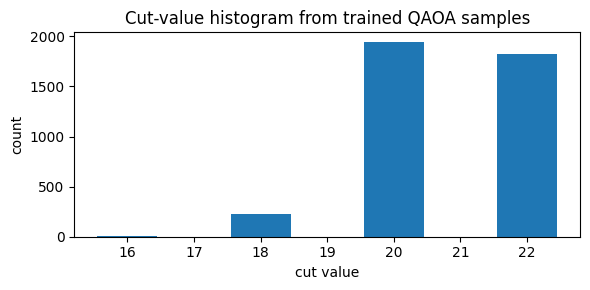

In [10]:
shots = 4000
samples = pennylane_sample_small(
    circuit=circuit,
    thetas=best_thetas.detach().cpu(),
    n_qubits=n_qubits,
    shots=shots,
    max_qubits=20,
    seed=0,
)
samples_np = samples.detach().cpu().numpy().astype(np.uint8)

cuts = np.array([cut_value_from_bits(row.tolist(), edges) for row in samples_np], dtype=np.float64)
print('sampled mean cut:', float(np.mean(cuts)))
print('sampled best cut:', int(np.max(cuts)))
print('fraction optimal:', float(np.mean(cuts == best_cut)))

plt.figure(figsize=(6, 3))
plt.hist(cuts, bins=np.arange(cuts.min(), cuts.max() + 2) - 0.5, rwidth=0.9)
plt.xlabel('cut value')
plt.ylabel('count')
plt.title('Cut-value histogram from trained QAOA samples')
plt.tight_layout()
plt.show()

## Reading results

- `sum<ZZ>` down -> expected cut up
- `qaoa best expected cut` close to classical max cut means good optimization
- sample histogram shows how concentrated trained circuit is on good cuts